## Import libraries and load data

In [ ]:
import pandas as pd
import numpy as np

# For cleaning the text
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import regex as re
import string

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth', None)

# For building our model
import tensorflow.keras
import sklearn
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/data/train.csv') 
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [ ]:
test = pd.read_csv('/content/drive/MyDrive/data/test.csv')
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
ids = test.id

print('Total length of the dataset: ', len(train)+len(test))
print('shape of training set: ', train.shape)
print('shape of testing set: ', test.shape)

Total length of the dataset:  10876
shape of training set:  (7613, 5)
shape of testing set:  (3263, 4)


## Clean Data

In [ ]:
nlp = spacy.load('en_core_web_sm')

nltk.download('stopwords')
nltk.download('punkt')

# spacy (362 words)
spacy_st = nlp.Defaults.stop_words
# nltk(179 words)
nltk_st = stopwords.words('english')

def clean(tweet, http = True, punc = True, lem = True, stop_w = True):
    
    if http is True:
        tweet = re.sub("https?:\/\/t.co\/[A-Za-z0-9]*", '', tweet)

    # stop words
    if stop_w == 'nltk':
        tweet = [word for word in word_tokenize(tweet) if not word.lower() in nltk_st]
        tweet = ' '.join(tweet)

    elif stop_w == 'spacy':
        tweet = [word for word in word_tokenize(tweet) if not word.lower() in spacy_st]
        tweet = ' '.join(tweet)

    # lemmitizing
    if lem == True:
        lemmatized = [word.lemma_ for word in nlp(tweet)]
        tweet = ' '.join(lemmatized)

    # punctuation removal
    if punc is True:
        tweet = tweet.translate(str.maketrans('', '', string.punctuation))
        
    # removing extra space
    tweet = re.sub("\s+", ' ', tweet)
    
    return tweet

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# apply function to clean data
train['cleaned_text'] = train.text.apply(lambda x: clean(x, lem = False, stop_w = 'nltk', http = True, punc = True))
test['cleaned_text'] = test.text.apply(lambda x: clean(x, lem = False, stop_w = 'nltk', http = True, punc = True))

In [ ]:
# convert to lower
train['cleaned_text'] = train['cleaned_text'].apply(lambda x:x.lower())
test['cleaned_text'] = test['cleaned_text'].apply(lambda x:x.lower())


In [ ]:
train

,id,keyword,location,text,target,cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,residents asked shelter place notified officers evacuation shelter place orders expected
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,13000 people receive wildfires evacuation orders california
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,got sent photo ruby alaska smoke wildfires pours school
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1,two giant cranes holding bridge collapse nearby homes
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1,ariaahrary thetawniest control wild fires california even northern part state troubling
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1,m194 0104 utc 5km volcano hawaii
7611,10872,NaN,NaN,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1,police investigating ebike collided car little portugal ebike rider suffered serious nonlife threatening injuries


In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(train, test_size=0.15, random_state=42)
eval_df, test_df = train_test_split(test_df, test_size=0.50, random_state=42)

In [ ]:
train_df

,id,keyword,location,text,target,cleaned_text
2318,3334,demolished,Chicago,ÛÏ@SplottDave: @TeamPalestina That's about 28700 Palestinian homes demolished now by Israel since 1967 w/ 0 Israeli home demolished @POTUS,1,ûï splottdave teampalestina s 28700 palestinian homes demolished israel since 1967 w 0 israeli home demolished potus
6341,9064,structural%20failure,Asia,Rightways: Building structural integrity &amp; failure: inspections damages defects testing repair http://t.co/vz1irH0Nmm via @rightwaystan,1,rightways building structural integrity amp failure inspections damages defects testing repair via rightwaystan
1097,1587,bombed,IDN,London Life: photos of a beautiful bombed-out Britain http://t.co/2RAcaiVFfq #arts,0,london life photos beautiful bombedout britain arts
548,797,battle,NaN,CIVIL WAR GENERAL BATTLE BULL RUN HERO COLONEL 2nd NEW HAMPSHIRE LETTER SIGNED ! http://t.co/Ot0tFFpBYB http://t.co/zaRBwep9LD,1,civil war general battle bull run hero colonel 2nd new hampshire letter signed
6521,9325,survive,? icon by @Hashiren_3 ?,@mochichiiiii @hikagezero IT'S IMPOSSIBLE FOR ME TOO WW like i can't survive a day without meat wew,0,mochichiiiii hikagezero s impossible ww like ca nt survive day without meat wew
...,...,...,...,...,...,...
5226,7470,obliteration,Merica!,@Eganator2000 There aren't many Obliteration servers but I always like to play when there are :D,0,eganator2000 nt many obliteration servers always like play
5390,7691,panic,NaN,just had a panic attack bc I don't have enough money for all the drugs and alcohol I wanted to buy this year let alone my fall bills,0,panic attack bc nt enough money drugs alcohol wanted buy year let alone fall bills
860,1242,blood,NaN,Omron HEM-712C Automatic Blood Pressure Monitor STANDARD AND LARGE BP CUFFS http://t.co/gJBAInQWN9 http://t.co/jPhgpL1c5x,0,omron hem712c automatic blood pressure monitor standard large bp cuffs
7603,10862,NaN,NaN,Officials say a quarantine is in place at an Alabama home over a possible Ebola case after developing symptoms... http://t.co/rqKK15uhEY,1,officials say quarantine place alabama home possible ebola case developing symptoms


### Tokenize

In [ ]:
#!pip install bert-tensorflow
!pip install bert-for-tf2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from bert import bert_tokenization
BertTokenizer = bert_tokenization.FullTokenizer

In [ ]:
BertTokenizer = bert_tokenization.FullTokenizer

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",
                            trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [ ]:
# Test tokenizer
sentence = 'Terrorist will crush the Tower'
print('Tokenized version of {} is : \n {} '.format(sentence, tokenizer.tokenize(sentence)))

Tokenized version of Terrorist will crush the Tower is : 
 ['terrorist', 'will', 'crush', 'the', 'tower'] 


In [ ]:
def tokenize_tweets(text_):
    return tokenizer.convert_tokens_to_ids(['[CLS]'] + tokenizer.tokenize(text_) + ['[SEP]'])

In [ ]:
train_df['tokenized_tweets'] = train_df.cleaned_text.apply(lambda x: tokenize_tweets(x))
train_df.head(2)

,id,keyword,location,text,target,cleaned_text,tokenized_tweets
2318,3334,demolished,Chicago,ÛÏ@SplottDave: @TeamPalestina That's about 28700 Palestinian homes demolished now by Israel since 1967 w/ 0 Israeli home demolished @POTUS,1,ûï splottdave teampalestina s 28700 palestinian homes demolished israel since 1967 w 0 israeli home demolished potus,"[101, 21318, 11867, 10994, 2102, 29045, 2063, 2136, 12952, 4355, 3981, 1055, 23090, 8889, 9302, 5014, 7002, 3956, 2144, 3476, 1059, 1014, 5611, 2188, 7002, 8962, 2271, 102]"
6341,9064,structural%20failure,Asia,Rightways: Building structural integrity &amp; failure: inspections damages defects testing repair http://t.co/vz1irH0Nmm via @rightwaystan,1,rightways building structural integrity amp failure inspections damages defects testing repair via rightwaystan,"[101, 2157, 14035, 2311, 8332, 11109, 23713, 4945, 29589, 12394, 18419, 5604, 7192, 3081, 2157, 14035, 5794, 102]"


In [ ]:
# what is the maximum length of our tokenized text?
max_len = len(max(train_df.tokenized_tweets, key = len))
print('The maximum length of each sequence besed on tokenized tweets is:', max_len)

The maximum length of each sequence besed on tokenized tweets is: 53


### Padded Tweets

In [ ]:
train_df['padded_tweets'] = train_df.tokenized_tweets.apply(lambda x: x + [0] * (max_len - len(x)))
train_df.head(2)

,id,keyword,location,text,target,cleaned_text,tokenized_tweets,padded_tweets
2318,3334,demolished,Chicago,ÛÏ@SplottDave: @TeamPalestina That's about 28700 Palestinian homes demolished now by Israel since 1967 w/ 0 Israeli home demolished @POTUS,1,ûï splottdave teampalestina s 28700 palestinian homes demolished israel since 1967 w 0 israeli home demolished potus,"[101, 21318, 11867, 10994, 2102, 29045, 2063, 2136, 12952, 4355, 3981, 1055, 23090, 8889, 9302, 5014, 7002, 3956, 2144, 3476, 1059, 1014, 5611, 2188, 7002, 8962, 2271, 102]","[101, 21318, 11867, 10994, 2102, 29045, 2063, 2136, 12952, 4355, 3981, 1055, 23090, 8889, 9302, 5014, 7002, 3956, 2144, 3476, 1059, 1014, 5611, 2188, 7002, 8962, 2271, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
6341,9064,structural%20failure,Asia,Rightways: Building structural integrity &amp; failure: inspections damages defects testing repair http://t.co/vz1irH0Nmm via @rightwaystan,1,rightways building structural integrity amp failure inspections damages defects testing repair via rightwaystan,"[101, 2157, 14035, 2311, 8332, 11109, 23713, 4945, 29589, 12394, 18419, 5604, 7192, 3081, 2157, 14035, 5794, 102]","[101, 2157, 14035, 2311, 8332, 11109, 23713, 4945, 29589, 12394, 18419, 5604, 7192, 3081, 2157, 14035, 5794, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [ ]:
train_df

,id,keyword,location,text,target,cleaned_text,tokenized_tweets,padded_tweets
2318,3334,demolished,Chicago,ÛÏ@SplottDave: @TeamPalestina That's about 28700 Palestinian homes demolished now by Israel since 1967 w/ 0 Israeli home demolished @POTUS,1,ûï splottdave teampalestina s 28700 palestinian homes demolished israel since 1967 w 0 israeli home demolished potus,"[101, 21318, 11867, 10994, 2102, 29045, 2063, 2136, 12952, 4355, 3981, 1055, 23090, 8889, 9302, 5014, 7002, 3956, 2144, 3476, 1059, 1014, 5611, 2188, 7002, 8962, 2271, 102]","[101, 21318, 11867, 10994, 2102, 29045, 2063, 2136, 12952, 4355, 3981, 1055, 23090, 8889, 9302, 5014, 7002, 3956, 2144, 3476, 1059, 1014, 5611, 2188, 7002, 8962, 2271, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
6341,9064,structural%20failure,Asia,Rightways: Building structural integrity &amp; failure: inspections damages defects testing repair http://t.co/vz1irH0Nmm via @rightwaystan,1,rightways building structural integrity amp failure inspections damages defects testing repair via rightwaystan,"[101, 2157, 14035, 2311, 8332, 11109, 23713, 4945, 29589, 12394, 18419, 5604, 7192, 3081, 2157, 14035, 5794, 102]","[101, 2157, 14035, 2311, 8332, 11109, 23713, 4945, 29589, 12394, 18419, 5604, 7192, 3081, 2157, 14035, 5794, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1097,1587,bombed,IDN,London Life: photos of a beautiful bombed-out Britain http://t.co/2RAcaiVFfq #arts,0,london life photos beautiful bombedout britain arts,"[101, 2414, 2166, 7760, 3376, 18897, 5833, 3725, 2840, 102]","[101, 2414, 2166, 7760, 3376, 18897, 5833, 3725, 2840, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
548,797,battle,NaN,CIVIL WAR GENERAL BATTLE BULL RUN HERO COLONEL 2nd NEW HAMPSHIRE LETTER SIGNED ! http://t.co/Ot0tFFpBYB http://t.co/zaRBwep9LD,1,civil war general battle bull run hero colonel 2nd new hampshire letter signed,"[101, 2942, 2162, 2236, 2645, 7087, 2448, 5394, 4327, 3416, 2047, 7035, 3661, 2772, 102]","[101, 2942, 2162, 2236, 2645, 7087, 2448, 5394, 4327, 3416, 2047, 7035, 3661, 2772, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
6521,9325,survive,? icon by @Hashiren_3 ?,@mochichiiiii @hikagezero IT'S IMPOSSIBLE FOR ME TOO WW like i can't survive a day without meat wew,0,mochichiiiii hikagezero s impossible ww like ca nt survive day without meat wew,"[101, 9587, 5428, 5428, 28954, 2072, 7632, 2912, 3351, 6290, 2080, 1055, 5263, 1059, 2860, 2066, 6187, 23961, 5788, 2154, 2302, 6240, 2057, 2860, 102]","[101, 9587, 5428, 5428, 28954, 2072, 7632, 2912, 3351, 6290, 2080, 1055, 5263, 1059, 2860, 2066, 6187, 23961, 5788, 2154, 2302, 6240, 2057, 2860, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...
5226,7470,obliteration,Merica!,@Eganator2000 There aren't many Obliteration servers but I always like to play when there are :D,0,eganator2000 nt many obliteration servers always like play,"[101, 27889, 8844, 28332, 2692, 23961, 2116, 27885, 22779, 8156, 14903, 2467, 2066, 2377, 102]","[101, 27889, 8844, 28332, 2692, 23961, 2116, 27885, 22779, 8156, 14903, 2467, 2066, 2377, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
5390,7691,panic,NaN,just had a panic attack bc I don't have enough money for all the drugs and alcohol I wanted to buy this year let alone my fall bills,0,panic attack bc nt enough money drugs alcohol wanted buy year let alone fall bills,"[101, 6634, 2886, 4647, 23961, 2438, 2769, 5850, 6544, 2359, 4965, 2095, 2292, 2894, 2991, 8236, 102]","[101, 6634, 2886, 4647, 23961, 2438, 2769, 5850, 6544, 2359, 4965, 2095, 2292, 2894, 2991, 8236, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Constructing the Model

In [ ]:
class TweetClassifier:
    
    def __init__(self, tokenizer, bert_layer, max_len, lr = 0.0001,
                 epochs = 15, batch_size = 32,
                 activation = 'sigmoid', optimizer = 'SGD',
                 beta_1=0.9, beta_2=0.999, epsilon=1e-07,
                 metrics = 'accuracy', loss = 'binary_crossentropy'):
        
        self.lr = lr
        self.epochs = epochs
        self.max_len = max_len
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.bert_layer = bert_layer
        

        self.activation = activation
        self.optimizer = optimizer
        
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon =epsilon
        
        self.metrics = metrics
        self.loss = loss

        
    def encode(self, texts):
        
        all_tokens = []
        masks = []
        segments = []
        
        for text in texts:
            
            tokenized = self.tokenizer.convert_tokens_to_ids(['[CLS]'] + self.tokenizer.tokenize(text) + ['[SEP]'])
            
            len_zeros = self.max_len - len(tokenized)
            
            
            padded = tokenized + [0] * len_zeros
            mask = [1] * len(tokenized) + [0] * len_zeros
            segment = [0] * self.max_len
            
            all_tokens.append(padded)
            masks.append(mask)
            segments.append(segment)
        
        return np.array(all_tokens), np.array(masks), np.array(segments)


    def make_model(self):
        
        # Shaping the inputs to our model
        
        input_ids = Input(shape = (self.max_len, ), dtype = tf.int32, name = 'input_ids')
        
        input_mask = Input(shape = (self.max_len, ), dtype = tf.int32, name = 'input_mask')
        
        segment_ids = Input(shape = (self.max_len, ), dtype = tf.int32,  name = 'segment_ids')

        
        pooled_output, sequence_output = bert_layer([input_ids, input_mask, segment_ids] )



        clf_output = sequence_output[:, 0, :]
        
        out = tf.keras.layers.Dense(1, activation = self.activation)(clf_output)
        
        
        model = Model(inputs = [input_ids, input_mask, segment_ids], outputs = out)
        
        # define the optimizer

        if self.optimizer is 'SGD':
            optimizer = SGD(learning_rate = self.lr)

        elif self.optimizer is 'Adam': 
            optimizer = Adam(learning_rate = self.lr, beta_1=self.beta_1, beta_2=self.beta_2, epsilon=self.epsilon)

        model.compile(loss = self.loss, optimizer = self.optimizer, metrics = [self.metrics])
        
        print('Model is compiled with {} optimizer'.format(self.optimizer))
        
        return model
    
    
    
    
    def train(self, x):    
        
        checkpoint = ModelCheckpoint('model.h5', monitor='val_loss',
                                     save_best_only=True)
            
        
        model = self.make_model()
        
        X = self.encode(x['cleaned_text'])
        Y = x['target']
        
        model.fit(X, Y, shuffle = True, validation_split = 0.2, 
                  batch_size=self.batch_size, epochs = self.epochs,
                  callbacks=[checkpoint])
                
        print('Model is fit!')
        
            
    def predict(self, x):
        
        X_test_encoded = self.encode(x['cleaned_text'])
        best_model = tf.keras.models.load_model('model.h5',custom_objects={'KerasLayer':hub.KerasLayer})
        y_pred = best_model.predict(X_test_encoded)
        
        
        return y_pred

# Models

In [ ]:
# classifier.train(cleaned_train)  #lr = 0.001, act = sigmoid, opt

In [ ]:
#fine tune 1 
'''classifier = TweetClassifier(tokenizer = tokenizer, bert_layer = bert_layer,
                              max_len = max_len, lr = 0.001,
                              epochs = 5,  activation = 'sigmoid',
                              batch_size = 32,optimizer = 'Adam',
                              beta_1=0.9, beta_2=0.999, epsilon=1e-07)'''

"classifier = TweetClassifier(tokenizer = tokenizer, bert_layer = bert_layer,\n                              max_len = max_len, lr = 0.001,\n                              epochs = 5,  activation = 'sigmoid',\n                              batch_size = 32,optimizer = 'Adam',\n                              beta_1=0.9, beta_2=0.999, epsilon=1e-07)"

In [ ]:
# fine tune 2 
'''classifier = TweetClassifier(tokenizer = tokenizer, bert_layer = bert_layer,
                              max_len = max_len, lr = 0.001,
                              epochs = 10,  activation = 'sigmoid',
                              batch_size = 32,optimizer = 'SGD',
                              beta_1=0.9, beta_2=0.999, epsilon=1e-07)'''

"classifier = TweetClassifier(tokenizer = tokenizer, bert_layer = bert_layer,\n                              max_len = max_len, lr = 0.001,\n                              epochs = 10,  activation = 'sigmoid',\n                              batch_size = 32,optimizer = 'SGD',\n                              beta_1=0.9, beta_2=0.999, epsilon=1e-07)"

In [ ]:
# fine tune 3 
'''classifier = TweetClassifier(tokenizer = tokenizer, bert_layer = bert_layer,
                              max_len = max_len, lr = 0.001,
                              epochs = 10,  activation = 'tanh',
                              batch_size = 32,optimizer = 'ADAM',
                              beta_1=0.9, beta_2=0.999, epsilon=1e-07)'''


"classifier = TweetClassifier(tokenizer = tokenizer, bert_layer = bert_layer,\n                              max_len = max_len, lr = 0.001,\n                              epochs = 10,  activation = 'tanh',\n                              batch_size = 32,optimizer = 'ADAM',\n                              beta_1=0.9, beta_2=0.999, epsilon=1e-07)"

In [ ]:
# fine tune 4 
'''classifier = TweetClassifier(tokenizer = tokenizer, bert_layer = bert_layer,
                              max_len = max_len, lr = 0.001,
                              epochs = 10,  activation = 'relu',
                              batch_size = 32,optimizer = 'ADAM',
                              beta_1=0.9, beta_2=0.999, epsilon=1e-07)'''


"classifier = TweetClassifier(tokenizer = tokenizer, bert_layer = bert_layer,\n                              max_len = max_len, lr = 0.001,\n                              epochs = 10,  activation = 'relu',\n                              batch_size = 32,optimizer = 'ADAM',\n                              beta_1=0.9, beta_2=0.999, epsilon=1e-07)"

In [ ]:
# fine tune 3 
classifier = TweetClassifier(tokenizer = tokenizer, bert_layer = bert_layer,
                              max_len = max_len, lr = 0.001,
                              epochs = 10,  activation = 'LeakyReLU',
                              batch_size = 32,optimizer = 'ADAM',
                              beta_1=0.9, beta_2=0.999, epsilon=1e-07)


In [ ]:
classifier.train(train_df)

Model is compiled with ADAM optimizer
Epoch 1/10
162/162 [==============================] - 45s 168ms/step - loss: 1.5598 - accuracy: 0.6343 - val_loss: 1.0073 - val_accuracy: 0.6664
Epoch 2/10
162/162 [==============================] - 27s 166ms/step - loss: 0.8203 - accuracy: 0.7145 - val_loss: 0.8074 - val_accuracy: 0.7166
Epoch 3/10
162/162 [==============================] - 25s 154ms/step - loss: 0.7315 - accuracy: 0.7353 - val_loss: 0.8309 - val_accuracy: 0.7089
Epoch 4/10
162/162 [==============================] - 25s 153ms/step - loss: 0.8768 - accuracy: 0.7344 - val_loss: 0.8409 - val_accuracy: 0.7228
Epoch 5/10
162/162 [==============================] - 26s 163ms/step - loss: 0.7057 - accuracy: 0.7392 - val_loss: 0.7180 - val_accuracy: 0.7251
Epoch 6/10
162/162 [==============================] - 25s 153ms/step - loss: 0.6736 - accuracy: 0.7378 - val_loss: 0.7513 - val_accuracy: 0.7336
Epoch 7/10
162/162 [==============================] - 26s 164ms/step - loss: 0.6188 - accura

In [ ]:
test_pred = classifier.predict(test_df)

18/18 [==============================] - 3s 122ms/step


In [ ]:
len(test_df)

571

In [ ]:
l1 = []
for i in range(len(test_df)):
  l1.append(test_pred[i][0])
l1

[1.0117741,
 0.30237588,
 0.1916903,
 0.4508098,
 0.8691407,
 0.86505824,
 0.7202499,
 0.25404304,
 0.8875141,
 0.34351778,
 0.30191004,
 0.16099022,
 0.54908794,
 0.6277659,
 0.1244848,
 0.6851838,
 0.031554814,
 1.5213033,
 0.63913894,
 0.3940557,
 1.0453237,
 0.19205947,
 0.7219536,
 0.25705597,
 1.3434296,
 0.31278044,
 0.9202205,
 0.20893018,
 1.5128396,
 0.8283503,
 0.4880213,
 0.8270721,
 0.06544341,
 0.9586524,
 1.1646051,
 0.51459646,
 0.9686784,
 0.47689736,
 0.1375815,
 0.23627351,
 0.49103427,
 0.41905063,
 0.9691211,
 -0.04319956,
 -0.03310415,
 0.33143958,
 0.72566336,
 0.3489202,
 0.067008205,
 0.24022618,
 0.8017598,
 0.99627674,
 0.5127234,
 0.36878404,
 0.15151401,
 0.8074735,
 0.46847668,
 0.82118046,
 0.5252204,
 0.31952822,
 0.8852358,
 0.42714727,
 0.9273331,
 0.52102077,
 0.9323753,
 0.0594499,
 0.3099868,
 0.056671668,
 0.54119396,
 0.8355047,
 0.05141454,
 0.7466792,
 0.45153463,
 0.4813585,
 0.0716247,
 1.4010414,
 0.73163587,
 0.71468323,
 0.9736814,
 0.35181

In [ ]:
test_df['p'] = l1

In [ ]:
test_df

,id,keyword,location,text,target,cleaned_text,p
5113,7292,nuclear%20disaster,Fukushima city Fukushima.pref,Over half of poll respondents worry nuclear disaster fading from public consciousness http://t.co/YtnnnD631z ##fukushima,0,half poll respondents worry nuclear disaster fading public consciousness fukushima,1.011774
6119,8735,sinking,NaN,That horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time,1,horrible sinking feeling youûªve home phone realise 3g whole time,0.302376
6076,8681,sinkhole,Greenpoint,@DavidCovucci We can't because a sinkhole swallowed every taco place in the neighborhood,0,davidcovucci ca nt sinkhole swallowed every taco place neighborhood,0.191690
1129,1627,bombed,texas a&m university,A wasp just dive bombed my face,0,wasp dive bombed face,0.450810
3794,5386,fire%20truck,Los Angeles,133 N past the 5 L lane is reopened. All other lanes are closed. All lanes are open on the 133 S. Trash truck fire cleanup. @KNX1070,1,133 n past 5 l lane reopened lanes closed lanes open 133 s trash truck fire cleanup knx1070,0.869141
...,...,...,...,...,...,...,...
5023,7164,mudslide,IUPUI '19,Someone split a mudslide w me when I get off work,0,someone split mudslide w get work,0.248284
2418,3477,derailed,US,Breakfast links: Work from home: Derailed: An empty train derailed at Smithsonian this morning suspending ser... http://t.co/iD4QGqDnJQ,1,breakfast links work home derailed empty train derailed smithsonian morning suspending ser,0.584689
3357,4807,evacuated,West,Rocky fire in Northern California swells to 60000 acres; 12000 evacuated http://t.co/mtfnbhRYZq Portland #Phoenix #Miami #Atlanta #Casper,1,rocky fire northern california swells 60000 acres 12000 evacuated portland phoenix miami atlanta casper,1.056259
1606,2318,collapse,Location,I get this feeling that society will collapse or implode. So don't be a hero and play your part.,0,get feeling society collapse implode nt hero play part,0.367817


In [ ]:
test_df['target_pred'] = (test_df['p'] > 0.5).astype(int)

In [ ]:
def compute_accuracy(y_true, y_pred):
    correct_predictions = 0
    # iterate over each label and check
    for true, predicted in zip(y_true, y_pred):
        if true == predicted:
            correct_predictions += 1
    # compute the accuracy
    accuracy = correct_predictions/len(y_true)
    return accuracy

In [ ]:
compute_accuracy(test_df['target'], test_df['target_pred'])

0.7390542907180385

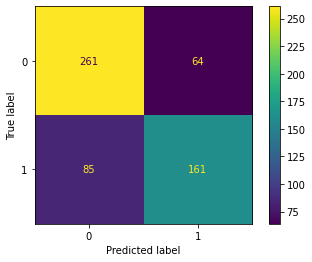

In [ ]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics


confusion_matrix = metrics.confusion_matrix(test_df['target'], test_df['target_pred'])

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()